In [46]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn import preprocessing
import requests
import io
import zipfile

'''

Training Model

# requires gt_corpus.csv
# global activation function works quite well atm

'''

import pandas as pd

df = pd.read_csv('gt_corpus.csv')
classes = len(df['class'].unique())
le = preprocessing.LabelEncoder()
targets = le.fit_transform(df['task'])
data = {'corpus':list(df['text']),'labels':targets}
data.keys()

dict_keys(['corpus', 'labels'])

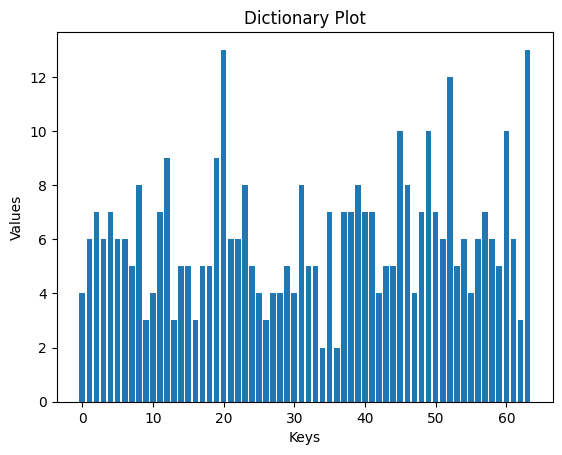

In [45]:
from collections import Counter
import matplotlib.pyplot as plt

ldata = dict(Counter(targets))

# Extract keys and values from the dictionary
keys = list(data.keys())
values = list(data.values())

# Create a bar plot using Matplotlib
plt.bar(keys, values)
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Dictionary Plot')
plt.show()

In [56]:
# define corpus
corpus = df
classes = len(corpus['class'].unique())

'''

Load the base models

            & send it to GPU

'''

# Load the pre-trained BERT model and tokenizer
model_name = 'prajjwal1/bert-mini'
# model_name = 'prajjwal1/bert-small'
# model_name = 'bert-base-uncased'
tokeniser = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
'''

Read Fine-Tuned Classifier Model (in Archived Format)

            Load model called in module

'''

# def download_and_extract_zip(url, extract_path):
#     # Send a GET request to the GitHub raw URL to download the ZIP file
#     response = requests.get(url)

#     # Check if the request was successful
#     if response.status_code == 200:
#         # Create a file-like object from the downloaded content
#         zip_file = io.BytesIO(response.content)

#         # Extract the contents of the ZIP file to the specified extract path
#         with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#             zip_ref.extractall(extract_path)
#         print(f"ZIP file extracted to {extract_path}")
#     else:
#         print(f"Failed to download ZIP file from {url}")

# download_and_extract_zip('https://github.com/mllibs/mllibs/raw/main/data/models/bert_classifier_model.zip', 'local_classifier')
# model = BertForSequenceClassification.from_pretrained('local_classifier')

In [59]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

model.to(device)

# Sample dataset for text classification
class CustomDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return {'text': text, 'label': label}

dataset = CustomDataset(list(data['corpus']),
                        list(data['labels']))

def train_bert(dataset,tokeniser,model):

    # Define batch size and create data loader
    batch_size = 10
    dataloader = DataLoader(dataset,
                            sampler=RandomSampler(dataset),
                            batch_size=batch_size)

    # Set up optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=1e-5)
    criterion = nn.CrossEntropyLoss()
    total_steps = len(dataloader) * 2

    num_epochs = 300

    # Train the model
    model.train()
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0
        y_true = []
        y_pred = []
        for batch in dataloader:

            # batch contains text (needs to be tokenised), label
            inputs = tokeniser(batch['text'], padding=True, truncation=True, return_tensors='pt')
            inputs.to(device)
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(dataloader)
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')

        if(epoch % 25 == 0):
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, F1 (weighted): {epoch_f1_weighted:.4f}, F1 (macro): {epoch_f1_macro:.4f}')

        # Calculate accuracy
        predicted_labels = torch.argmax(outputs.logits, dim=1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    # accuracy = total_correct / total_samples
    # print(f'Epoch {epoch+1} completed. Accuracy: {accuracy:.4f}')
    return model

model = train_bert(dataset,tokeniser,model)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/300], Loss: 1.7921, F1 (weighted): 0.9253, F1 (macro): 0.8960
Epoch [26/300], Loss: 1.2785, F1 (weighted): 0.9638, F1 (macro): 0.9403
Epoch [51/300], Loss: 0.8872, F1 (weighted): 0.9945, F1 (macro): 0.9899
Epoch [76/300], Loss: 0.6108, F1 (weighted): 0.9945, F1 (macro): 0.9898
Epoch [101/300], Loss: 0.4245, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [126/300], Loss: 0.2890, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [151/300], Loss: 0.2032, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [176/300], Loss: 0.1413, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [201/300], Loss: 0.0981, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [226/300], Loss: 0.0722, F1 (weighted): 0.9974, F1 (macro): 0.9960
Epoch [251/300], Loss: 0.0533, F1 (weighted): 0.9949, F1 (macro): 0.9922
Epoch [276/300], Loss: 0.0373, F1 (weighted): 0.9974, F1 (macro): 0.9960


In [ ]:
# model = model.to('cpu')
model.save_pretrained('bert_classifier_model')

In [ ]:
'''

Create Archive of Model Folder

'''

import zipfile
import os

def create_zip_archive(folder_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Example usage
colab_folder_path = "/content/bert_classifier_model"  # Replace with the path of your folder in Colab
local_save_path = "bert_classifier_model.zip"  # Path where you want to save the downloaded ZIP file
create_zip_archive(colab_folder_path, local_save_path)
print(f"Folder archived and saved as {local_save_path}")

Folder archived and saved as bert_classifier_model.zip


In [61]:
'''

II Inference with Transformer Encoder

'''

model.to('cpu')

def inference(text,tokeniser,model):

    # Tokenize the input text
    inputs = tokeniser(input_text,
                       padding=True,
                       truncation=True,
                       return_tensors='pt')

    # Perform inference using the model
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get the predicted label
    predicted_label = torch.argmax(logits, dim=1).item()

    # Print the predicted label
    print(f"The predicted label for the input text is: {le.classes_[predicted_label]}")

In [ ]:
# fine
# input_text = "I'd like you to create a seaborn scatterplot" # 61
# input_text = "I want to plot a figure using the seaborn scatter plot" # 61
input_text = "create plotly count heatmap x: bill_depth_mm y: flipper_length_mm hue: island col: island using penguins"
inference(input_text,tokeniser,model)

The predicted label for the input text is: plheatmap


In [66]:
# The predicted label for the input text is: col_scatter # incorrect (full) (mini)
# The predicted label for the input text is: embed_sgns # incorrect (full) (small)
# full bert also incorrectly classified, ie. problem with data input and/or trained samples
# [need test] need to include parameter training samples or not?

# input_text = "I'd like you to create a scatterplot using plotly set parameters as x: bill_depth_mm y: flipper_length_mm hue: island col: island using penguins" # too much
input_text = "I'd like you to create a scatterplot using plotly set parameters as" # ok (filtered parameters & data)
inference(input_text,tokeniser,model)

The predicted label for the input text is: plscatter


In [67]:
# The predicted label for the input text is: col_scatter incorrect (mini)

input_text = "create a scatter plot using plotly set parameters as x: bill_depth_mm y: flipper_length_mm hue: island col: island using penguins" # mini works
inference(input_text,tokeniser,model)

The predicted label for the input text is: plscatter


In [68]:
# extraction of parameters only (which works well with QA) improves accuracy
input_text = "create a scatter plot using plotly using penguins"
inference(input_text,tokeniser,model)

The predicted label for the input text is: plscatter


In [69]:
input_text = "generate me a scatter plot using seaborn with parameters x: A, y: B and use data penguins" # mini works fine
inference(input_text,tokeniser,model)

The predicted label for the input text is: sscatterplot
